In [14]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import plotly.io as pio
from plotly.subplots import make_subplots 
import importlib
from jw_utils import rna_seq_utils as rsu
from jw_utils import plotly_preferences as pprefs
from jw_utils import parse_gff as pgf
from pathlib import Path

#### Fill out these filepaths:

In [10]:
gff_fp = './references/genomic.gff'
samplesheet_fp = './assets/samplesheet.csv'
contrast_fp = './assets/contrasts.csv'
subread_dir = './results/featureCounts_30/'
pval_cutoff = 0.05
FC_cutoff = 2

## Make sample info and contrasts csvs

In [3]:
samplesheet_df = pd.read_csv(samplesheet_fp)
samplesheet_df.head(5)

sample                                            fastq_1  \
0  wt_1_light  s3://mukherjee-lab/dimA_RNA_seq_2025/raw/24121...   
1  wt_2_light  s3://mukherjee-lab/dimA_RNA_seq_2025/raw/24121...   
2  wt_3_light  s3://mukherjee-lab/dimA_RNA_seq_2025/raw/24121...   
3   wt_1_dark  s3://mukherjee-lab/dimA_RNA_seq_2025/raw/24121...   
4   wt_2_dark  s3://mukherjee-lab/dimA_RNA_seq_2025/raw/24121...   

                                             fastq_2 strandedness condition  \
0  s3://mukherjee-lab/dimA_RNA_seq_2025/raw/24121...      reverse  wt_light   
1  s3://mukherjee-lab/dimA_RNA_seq_2025/raw/24121...      reverse  wt_light   
2  s3://mukherjee-lab/dimA_RNA_seq_2025/raw/24121...      reverse  wt_light   
3  s3://mukherjee-lab/dimA_RNA_seq_2025/raw/24121...      reverse   wt_dark   
4  s3://mukherjee-lab/dimA_RNA_seq_2025/raw/24121...      reverse   wt_dark   

   replicate  
0          1  
1          2  
2          3  
3          1  
4          2

In [4]:
samp_info_df = samplesheet_df[['sample', 'condition']].rename(columns={'condition':'group'})
samp_info_df.head(5)

sample     group
0  wt_1_light  wt_light
1  wt_2_light  wt_light
2  wt_3_light  wt_light
3   wt_1_dark   wt_dark
4   wt_2_dark   wt_dark

In [5]:
contrast_df = pd.read_csv(contrast_fp, index_col=0)[['variable', 'target', 'reference']]
contrast_df = contrast_df.rename(columns={'variable':'group', 'target':'up'}).reset_index()
contrast_df

id      group          up   reference
0       wt_light-vs-wt_dark  condition    wt_light     wt_dark
1   dimA_light-vs-dimA_dark  condition  dimA_light   dimA_dark
2    dimA_light-vs-wt_light  condition  dimA_light    wt_light
3      dimA_dark-vs-wt_dark  condition   dimA_dark     wt_dark
4    bphP_light-vs-wt_light  condition  bphP_light    wt_light
5  dimA_light-vs-bphP_light  condition  dimA_light  bphP_light
6     bphP_light-vs-wt_dark  condition  bphP_light     wt_dark

In [6]:
importlib.reload(rsu)
comp_dfs_d = rsu.make_comparison_df_dict(samp_info_df, contrast_df, 
                            subread_dir=subread_dir, 
                            file_suffix = '_T1.txt',
                           )
stat_dfs = rsu.make_stats_df(comp_dfs_d)


In [16]:
manual_analysis_dir = Path('./results/analysis/all_comparisons/')
Path(manual_analysis_dir).mkdir(exist_ok=True)
for name, df in stat_dfs.items():
    df.to_csv(manual_analysis_dir / f'{name}_manual_stats.csv')
    

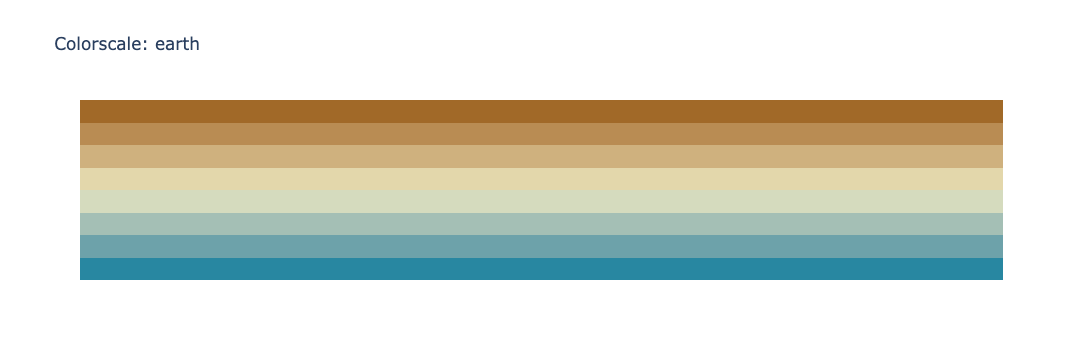

In [8]:
importlib.reload(pprefs)
colors = pprefs.interpolate_colorscale(colorscale_name='earth', n=8)
pprefs.plot_colorscale('earth', n=8)

In [9]:
coi_stat_dfs = {}
coi_stat_dfs['wt_light-vs-wt_dark'] = stat_dfs['wt_light-vs-wt_dark']
coi_stat_dfs['dimA_light-vs-dimA_dark'] = stat_dfs['dimA_light-vs-dimA_dark']

def make_volc_plot(stat_df_d,
                   xrange=[-5,5], 
                   yrange=[-0.5,6],
                   up_color = "rgb(255,190,15)",
                   down_color = "rgb(100,100,100)",
                   FC_cutoff = 2, 
                   pval_cutoff = 0.05,
                  ):
    "Stat"
    
    def get_str(comp):
        clst = comp.split('_v_')
        return f'{comp}<br>Down in {clst[0]}     |    Up in {clst[0]}'
    
    subplot_titles=[get_str(comp) for comp in stat_df_d]  
    yline= [-np.log10(pval_cutoff), -np.log10(pval_cutoff)]
    VR_xline= [np.log2(FC_cutoff), np.log2(FC_cutoff)]
    VL_xline= [-np.log2(FC_cutoff), -np.log2(FC_cutoff)]
    
    fig = make_subplots(rows=1, cols=len(stat_df_d), vertical_spacing=0.1,
                        shared_xaxes=True, subplot_titles=subplot_titles)
    fig.update_yaxes(range=yrange)
    fig.update_xaxes(range=xrange)
    for i, (comparison, df) in enumerate(stat_df_d.items(), start=1):  
        df = df.drop('pvals', axis=1)
        colors = pprefs.interpolate_colorscale(colorscale_name='earth', n=8)
        up_volcano_trace, down_volc_trace, nonsig_volcano_trace = rsu.get_volc_traces(df, text_annots=True, gff_fp=gff_fp,
                                                         pval_cutoff=pval_cutoff, FC_cutoff=FC_cutoff,
                                                         up_reg_color=up_color, 
                                                         down_reg_color=down_color,
                                                         marker_size_sig=4)
        
        fig.add_trace(up_volcano_trace, row=1, col=i)
        fig.add_trace(down_volc_trace, row=1, col=i)
        fig.add_trace(nonsig_volcano_trace, row=1, col=i)
        fig.update_yaxes(title=f'-log10 p-value', row=1, col=i)
        fig = rsu.add_cutoff_traces(fig, pval_cutoff, FC_cutoff, row=1, col=i)
        fig.update_xaxes(title=f'log2 fold change', row=1, col=i)
    fig.update_layout(template='simple_white', height= 200*len(stat_df_d), width= 800)
    
    return fig

fig = make_volc_plot(coi_stat_dfs)
pio.write_html(fig, os.path.join(analysis_dir, f'volcano_pval_{pval_cutoff}_FC_{FC_cutoff}.html'))
pio.write_image(fig, os.path.join(analysis_dir, f'volcano_pval_{pval_cutoff}_FC_{FC_cutoff}.pdf'))
fig

NameError: name 'analysis_dir' is not defined

In [ ]:
analysis_dir

In [94]:
regulon_d = {}
for comparison, df in coi_stat_dfs.items():
    light_activated = f'{comparison}_upregulated'
    light_repressed = f'{comparison}_downregulated'
    FC_upregulated = df['log2_FC'] > np.log2(2)
    FC_downregulated = df['log2_FC'] < -np.log2(2)
    pval_f = df['pvals'] < 0.05
    df_up = df[FC_upregulated & pval_f]
    df_down = df[FC_downregulated & pval_f]
    regulon_d[light_activated] = list(df_up.index)
    regulon_d[light_repressed] = list(df_down.index)
regulon_d.keys()

dict_keys(['wt_light-vs-wt_dark_upregulated', 'wt_light-vs-wt_dark_downregulated', 'dimA_light-vs-dimA_dark_upregulated', 'dimA_light-vs-dimA_dark_downregulated'])

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

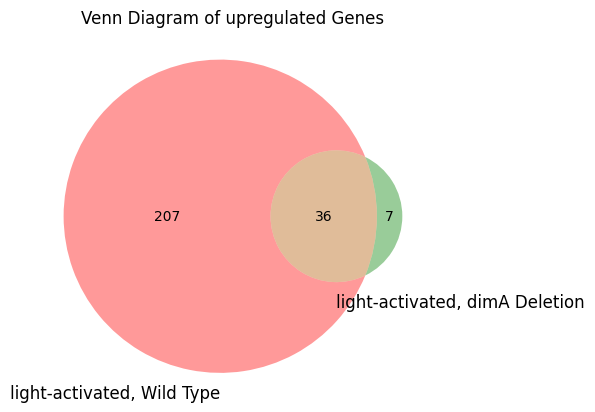

In [100]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

# Your gene sets
wild_type_activated = set(regulon_d['wt_light-vs-wt_dark_upregulated'])
dimA_deletion_activated = set(regulon_d['dimA_light-vs-dimA_dark_upregulated'])


# Create the Venn diagram
venn2([wild_type_activated, dimA_deletion_activated],
      set_labels=('light-activated, Wild Type', 'light-activated, dimA Deletion'))

plt.title("Venn Diagram of upregulated Genes")
plt.savefig('results/analysis/venn_light_activated_WTvsDelDimA.pdf', format='pdf')
plt

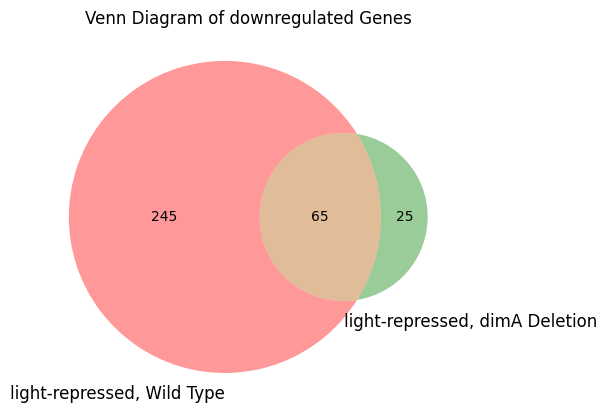

In [101]:
# Your gene sets
wild_type_repressed= set(regulon_d['wt_light-vs-wt_dark_downregulated'])
dimA_deletion_repressed = set(regulon_d['dimA_light-vs-dimA_dark_downregulated'])


# Create the Venn diagram
venn2([wild_type_repressed, dimA_deletion_repressed],
      set_labels=('light-repressed, Wild Type', 'light-repressed, dimA Deletion'))

plt.title("Venn Diagram of downregulated Genes")
plt.savefig('results/analysis/venn_light_repressed_WTvsDelDimA.pdf', format='pdf')

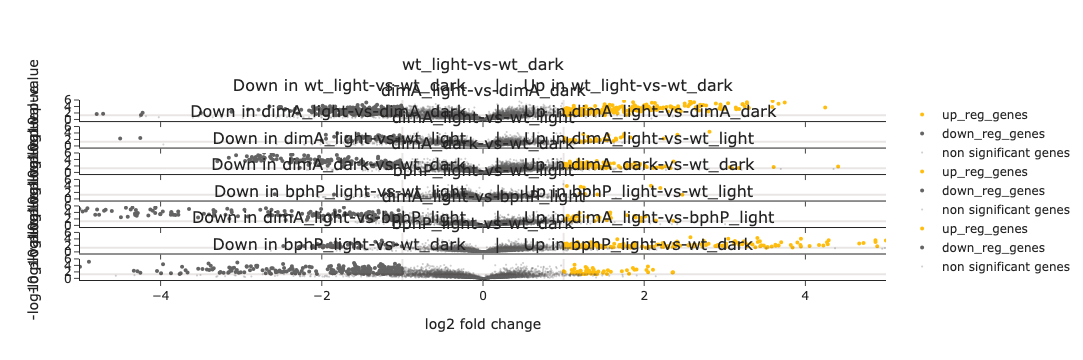

In [105]:
importlib.reload(rsu)
from plotly import graph_objects as go
xrange=[-5,5]
yrange=[-0.5,6]
yline= [-np.log10(pval_cutoff), -np.log10(pval_cutoff)]
VR_xline= [np.log2(FC_cutoff), np.log2(FC_cutoff)]
VL_xline= [-np.log2(FC_cutoff), -np.log2(FC_cutoff)]

analysis_dir = './results/analysis/'
os.makedirs(analysis_dir, exist_ok=True) 
importlib.reload(rsu)
def get_str(comp):
    clst = comp.split('_v_')
    return f'{comp}<br>Down in {clst[0]}     |    Up in {clst[0]}'
    
bphP = ['PA14_10700'] 
algB = ['PA14_72380']
up_color = "rgb(255,190,15)"
down_color = "rgb(100,100,100)"
subplot_titles=[get_str(comp) for comp in stat_dfs]
fig = make_subplots(rows=len(stat_dfs), cols=1, vertical_spacing=0.03,
                    shared_xaxes=True, subplot_titles=subplot_titles)
fig.update_yaxes(range=yrange)
fig.update_xaxes(range=xrange)
for i, (comparison, df) in enumerate(stat_dfs.items(), start=1):  
    df = df.drop('pvals', axis=1)
    colors = pprefs.interpolate_colorscale(colorscale_name='earth', n=8)
    up_volcano_trace, down_volc_trace, nonsig_volcano_trace = rsu.get_volc_traces(df, text_annots=True, gff_fp=gff_fp,
                                                     pval_cutoff=pval_cutoff, FC_cutoff=FC_cutoff,
                                                     up_reg_color=up_color, 
                                                     down_reg_color=down_color,
                                                     marker_size_sig=4)
    fig.add_trace(up_volcano_trace, row=i, col=1)
    fig.add_trace(down_volc_trace, row=i, col=1)
    fig.add_trace(nonsig_volcano_trace, row=i, col=1)
    fig.update_yaxes(title=f'-log10 p-value', row=i, col=1)
    fig = rsu.add_cutoff_traces(fig, pval_cutoff, FC_cutoff, row=i, col=1)
    

    # bphPtext = rsu.make_text_annot(df.loc[bphP], gff_fp,)
    # algBtext = rsu.make_text_annot(df.loc[algB], gff_fp,)
    # # bphP_trace = rsu.get_simple_volc_trace(list(df.loc[bphP]['log2_FC']), list(df.loc[bphP]['-log10_pval']), bphPtext,
    # #                              marker_size=10, marker_color='rgba(228,71,18,1)', name='bphP')
    # # algB_trace = rsu.get_simple_volc_trace(list(df.loc[algB]['log2_FC']), list(df.loc[algB]['-log10_pval']), algBtext,
    # #                              marker_size=10, marker_color='rgba(6,87,66,1)', name='algB')
    # # fig.add_trace(bphP_trace, row=i, col=1)
    # # fig.add_trace(algB_trace, row=i, col=1)
    
fig.update_layout(template='simple_white', height=400*len(stat_dfs))
fig.update_xaxes(title=f'log2 fold change', row=i, col=1)





pio.write_html(fig, os.path.join(analysis_dir, f'volcano_pval_{pval_cutoff}_FC_{FC_cutoff}.html'))
pio.write_image(fig, os.path.join(analysis_dir, f'volcano_pval_{pval_cutoff}_FC_{FC_cutoff}.pdf'))
fig


In [ ]:
'./results/featureCounts/'

In [136]:
importlib.reload(rsu)
for comparison, df in stat_dfs.items():
    df= df.drop('pvals', axis=1)
    if not df.index[0].startswith('gene-'):
        df.index=['gene-'+i for i in df.index]
    sig_genes_df = rsu.get_significant_genes_df(df, pval_cutoff, FC_cutoff, gff_fp)
    sig_genes_df.to_csv(os.path.join(analysis_dir, f'signif_genes_{comparison}_pval_{pval_cutoff}_FC_{FC_cutoff}.csv'))
    annot_df = pgf.make_simple_annot_df(gff_fp)

    full_annotated_df = df.join(annot_df)
    full_annotated_df.to_csv(os.path.join(analysis_dir, f'all_genes_{comparison}.csv'))

In [137]:
sig_genes_df.columns

Index(['bphP_light_mean_rpm', 'wt_dark_mean_rpm', 'log2_FC', '-log10_pval',
       'protein_ID', 'common_name', 'product'],
      dtype='object')

### Show what genes that are up-regulated in WT light vs Dark do in the dimA mutants

In [138]:
uplight_filter = stat_dfs['wt_light-vs-wt_dark']['log2_FC'] > np.log2(FC_cutoff)
sig_filt = stat_dfs['wt_light-vs-wt_dark']['pvals'] < pval_cutoff
genes_up_in_light = stat_dfs['wt_light-vs-wt_dark'][uplight_filter & sig_filt]
genes_up_in_light = list(genes_up_in_light.index)


In [ ]:
importlib.reload(rsu)
analysis_dir = './results/analysis/'
os.makedirs(analysis_dir, exist_ok=True) 
importlib.reload(rsu)
def get_str(comp):
    clst = comp.split('_v_')
    return f'{comp}<br>Down in {clst[0]}     |    Up in {clst[0]}'
    
algB = ['PA14_72380']
bphP = ['PA14_10700']
subplot_titles=[get_str(comp) for comp in stat_dfs]
fig = make_subplots(rows=len(stat_dfs), cols=1, vertical_spacing=0.03,
                    shared_xaxes=True, subplot_titles=subplot_titles)
fig.update_yaxes(range=[-0.5,6])
fig.update_xaxes(range=[-4,4])
for i, (comparison, df) in enumerate(stat_dfs.items(), start=1):
    df = df.drop('pvals', axis=1)
    colors = pprefs.interpolate_colorscale(colorscale_name='earth', n=8)
    xvals=df.iloc[:,2]
    yvals=df.iloc[:,3]
    all_trace = rsu.get_simple_volc_trace(xvals, yvals, hoverinfo='skip')
    
    df_upin_light = df.loc[genes_up_in_light,:]
    xvals=df_upin_light.iloc[:,2]
    yvals=df_upin_light.iloc[:,3]
    text = rsu.make_text_annot(df_upin_light, gff_fp, feature_type='gene')
    genes_uplight_trace = rsu.get_simple_volc_trace(xvals,yvals, marker_size=3, 
                                                    marker_color=colors[-2], text=text)
    ### add algB and bphP traces}}
    df_algB = df.loc[algB]
    algB_text = rsu.make_text_annot(df_algB, gff_fp, feature_type='gene')
    xvals=df_algB.iloc[:,2]
    yvals=df_algB.iloc[:,3]
    algB_trace = rsu.get_simple_volc_trace(xvals,yvals, marker_size=10, 
                                                    marker_color='rgb(228,71,18)',
                                                    text=algB_text, name='algB')
    

    df_bphP = df.loc[bphP]
    bphP_text = rsu.make_text_annot(df_algB, gff_fp, feature_type='gene')
    xvals=df_bphP.iloc[:,2]
    yvals=df_bphP.iloc[:,3]
    bphP_trace = rsu.get_simple_volc_trace(xvals,yvals, marker_size=10, 
                                                    marker_color='rgb(6,87,66)', 
                                                   text=bphP_text, name='bphP')
    
    


    

    fig.add_trace(all_trace, row=i, col=1)
    fig.add_trace(genes_uplight_trace, row=i, col=1)
    
    fig.update_yaxes(title=f'-log10 p-value', row=i, col=1)
    fig = rsu.add_cutoff_traces(fig,pval_cutoff,FC_cutoff, row=i, col=1)
    fig.add_trace(algB_trace, row=i, col=1)
    fig.add_trace(bphP_trace, row=i, col=1)

fig.update_layout(template='simple_white', height=400*len(stat_dfs))
fig.update_xaxes(title=f'log2 fold change', row=i, col=1)



pio.write_html(fig, os.path.join(analysis_dir, f'volcano_light_upreg_genes.html'))
pio.write_image(fig, os.path.join(analysis_dir, f'volcano_light_upreg_genes.pdf'))
fig
